# GRAPH - Graph Mining - CS - PARIS - SACLAY (2024-2025)
## Professor: Nacéra Seghouani

# Import Libraries

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import community as community_louvain  # Louvain algorithm
from networkx.algorithms.community import label_propagation_communities
from networkx.algorithms.community import asyn_lpa_communities
import itertools
from collections import defaultdict
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import linkage, fcluster
from node2vec import Node2Vec
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial import procrustes
import matplotlib.pyplot as plt

c:\Users\merte\cs\graph\tp1\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import Graph

In [2]:
def create_graph_from_tsv(filepath: str, num_nodes_to_consider: int) -> nx.Graph:
    """
    Reads a TSV file with edge list and creates a homogeneous graph.
    Only nodes with assigned integer IDs <= num_nodes_to_consider are included.
    
    The TSV file is expected to have two columns (source and target) separated by tab
    with no header. This version uses separate mappings for source (disease) and target (gene).
    
    Args:
        filepath: The path to the TSV file.
        num_nodes_to_consider: The maximum node id value to include.
        
    Returns:
        G: A NetworkX graph with edges only if both endpoints are <= num_nodes_to_consider.
    """
    G = nx.Graph()
    num_d = defaultdict(int)  # mapping for source (disease) nodes
    num_g = defaultdict(int)  # mapping for target (gene) nodes
    first_row = True
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) < 2:
                continue
            # If file has a header, skip the first line
            if first_row:
                first_row = False
                continue
            source, target = parts[0], parts[1]
            # Update disease mapping
            if source not in num_d:
                num_d[source] = len(num_d) + 1  # start IDs at 1
            # Update gene mapping
            if target not in num_g:
                num_g[target] = len(num_g) + 1
            source_id = num_d[source]
            target_id = num_g[target]
            if source_id <= num_nodes_to_consider and target_id <= num_nodes_to_consider:
                G.add_edge(source_id, target_id)
    return G


In [3]:
def create_hetero_graph_from_tsv(filepath: str, num_nodes_to_consider: int) -> nx.Graph:
    """
    Reads a TSV file with edge list and creates a heterogeneous graph using NetworkX, considering only nodes up to a specified number.

    The TSV file is expected to have two columns with no header, where each row represents an edge between two nodes of different categories.

    Args:
        filepath: The path to the TSV file containing the edge list.
        num_nodes_to_consider: The maximum node number to include in the graph.

    Returns:
        A NetworkX graph object created from the edge list in the TSV file, considering only the specified nodes, with node categories.
    """
    # Create a new graph
    G = nx.Graph()

    num_d = defaultdict(int)  # For diseases
    num_g = defaultdict(int)  # For genes
    first_row = True

    # Open the TSV file and read lines
    with open(filepath, 'r') as file:
        for line in file:
            # Skip header
            if first_row:
                first_row = False
                continue
            source, _, target = line.strip().split('\t')

            disease_id, disease_name, gene_id = line.strip().split('\t')
            # Update disease and gene mappings
            if source not in num_d:
                num_d[source] = 2*len(num_d) + 1  # Avoid 0 index
            if target not in num_g:
                num_g[target] = 2*len(num_g) + 2  # Avoid 0 index

            # Map to integers
            source_id, target_id = num_d[source], num_g[target]

            # Check if both nodes are within the specified limit
            if source_id <= num_nodes_to_consider and target_id <= num_nodes_to_consider:
              # Add nodes with their category if they haven't been added yet
              if source_id not in G:
                  G.add_node(source_id, category='disease', name=disease_name)
              if target_id not in G:
                  G.add_node(target_id, category='gene', name=gene_id)

              # Add edge between source and target
              G.add_edge(source_id, target_id)

    return G, num_d, num_g

In [4]:
def plot_hetero_graph(G: nx.Graph) -> None:
    """
    Plots a heterogeneous graph with nodes colored by category.
    
    Disease nodes (category='disease') are colored blue and gene nodes red.
    """
    color_map = ['blue' if G.nodes[node].get('category') == 'disease' else 'red' for node in G.nodes()]
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=False, node_color=color_map, edge_color='gray', node_size=30)
    plt.title("Heterogeneous Disease–Gene Graph (max nodes)")
    plt.show()


In [5]:
G, _, _= create_hetero_graph_from_tsv('data_disease\DG-AssocMiner_miner-disease-gene.tsv', num_nodes_to_consider=267328736821372)
print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph loaded with 7813 nodes and 21357 edges.


In [6]:
G_200_nodes, num_d, num_g = create_hetero_graph_from_tsv('data_disease\DG-AssocMiner_miner-disease-gene.tsv', num_nodes_to_consider=200)

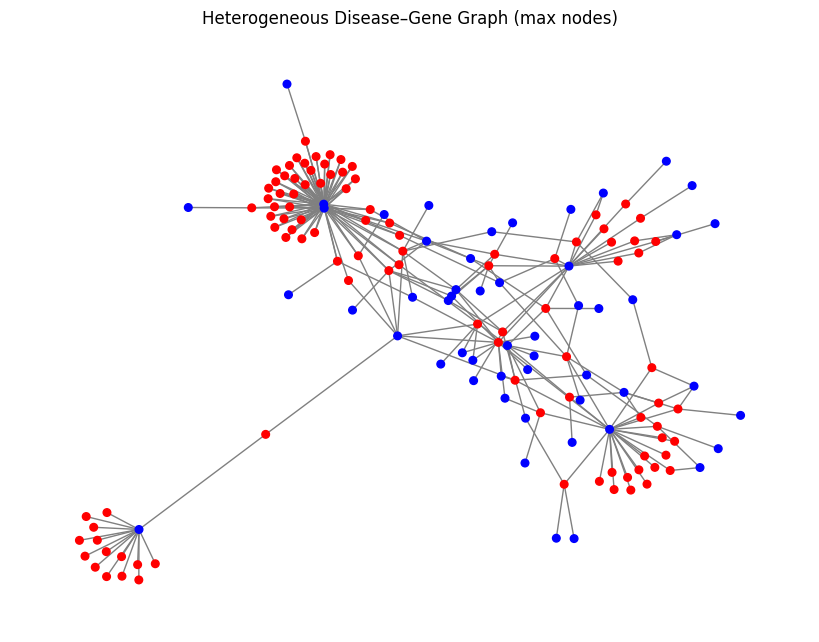

In [7]:
plot_hetero_graph(G_200_nodes)

# Centralities

In [47]:
import time


def compute_centralities(G: nx.Graph) -> dict:
    """
    Computes centrality measures for graph G.
    Returns a dictionary with keys as centrality measure names and values as node-to-score dictionaries.
    """
    centralities = {}
    t0 = time.time()
    centralities['degree'] = nx.degree_centrality(G)
    print("Degre centrality computation duration: ", str(time.time() - t0))

    t0 = time.time()
    centralities['avg_neighbor_degree'] = nx.average_neighbor_degree(G)
    print("Neighborhood connectivity computation duration: ", str(time.time() - t0))

    t0 = time.time()
    try:
        centralities['eigenvector'] = nx.eigenvector_centrality(G, max_iter=1000)
    except nx.PowerIterationFailedConvergence:
        print("Warning: Eigenvector centrality did not converge.")
        centralities['eigenvector'] = None
    print("Eigenvector centrality computation duration: ", str(time.time() - t0))

    t0 = time.time()
    try:
        centralities['katz'] = nx.katz_centrality_numpy(G)
    except Exception as e:
        print("Katz centrality error:", e)
        centralities['katz'] = None
    print("Katz centrality computation duration: ", str(time.time() - t0))

    t0 = time.time()
    centralities['pagerank'] = nx.pagerank(G)
    print("Pagerank centrality computation duration: ", str(time.time() - t0))

    t0 = time.time()
    centralities['clustering'] = nx.clustering(G)
    print("Clustering centrality computation duration: ", str(time.time() - t0))

    t0 = time.time()
    centralities['closeness'] = nx.closeness_centrality(G)
    print("Closeness centrality computation duration: ", str(time.time() - t0))

    # Betweenness takes too much time
    # t0 = time.time()
    # centralities['betweenness'] = nx.betweenness_centrality(G)
    # print("Betweenness centrality computation duration: ", str(time.time() - t0))

    return centralities


In [ ]:
def plot_centrality_histograms(centralities: dict) -> None:
    """
    Creates histograms for each available centrality measure.
    """
    num_measures = sum(1 for key, val in centralities.items() if val is not None)
    plt.figure(figsize=(15, 12))
    plot_index = 1
    for key, cent in centralities.items():
        if cent is None:
            continue
        values = list(cent.values())
        plt.subplot(3, 3, plot_index)
        plt.hist(values, bins=20, edgecolor='black')
        plt.title(f"{key.capitalize()} Centrality")
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plot_index += 1
    plt.tight_layout()
    plt.show()


In [67]:
def print_top5_by_category(cent_dict: dict, G: nx.Graph, measure_name: str) -> None:
    """
    Prints the top 5 disease nodes and top 5 gene nodes for a given centrality measure.
    The name and ID (from the node attributes) and the score are printed.
    """
    disease_vals = {n: val for n, val in cent_dict.items() if G.nodes[n].get('category') == 'disease'}
    gene_vals = {n: val for n, val in cent_dict.items() if G.nodes[n].get('category') == 'gene'}
    top5_diseases = sorted(disease_vals.items(), key=lambda x: x[1], reverse=True)[:5]
    top5_genes = sorted(gene_vals.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print(f"\nCentrality Measure: {measure_name.capitalize()}")
    print("  Top 5 Disease Nodes:")
    for node, score in top5_diseases:
        name = G.nodes[node].get('name', f"Node {node}")
        print(f"    {name} (ID: {node}) - {score:.4f}")
    print("  Top 5 Gene Nodes:")
    for node, score in top5_genes:
        name = G.nodes[node].get('name', f"Node {node}")
        print(f"    {name} (ID: {node}) - {score:.4f}")


In [66]:
def plot_graph_with_node_size(G: nx.Graph, cent: dict, title: str = "",
                              scale: float = 5000, highlight_size: float = 300) -> None:
    """
    Plots the graph with node sizes proportional to a given centrality measure.
    Additionally, nodes with the maximum centrality score are highlighted in yellow
    and drawn with a fixed size specified by highlight_size.
    
    Args:
      G: The graph.
      cent: Dictionary of centrality scores per node.
      title: Title for the plot.
      scale: Scaling factor applied to node size.
      highlight_size: The fixed node size for nodes with the highest centrality.
    """
    pos = nx.spring_layout(G, seed=42)
    max_val = max(cent.values())
    sizes = []
    colors = []
    for node in G.nodes():
        # If a node's centrality equals the maximum (within a tolerance), highlight it
        if abs(cent[node] - max_val) < 1e-6:
            sizes.append(highlight_size)
            colors.append('yellow')
        else:
            sizes.append(cent[node] * scale)
            if G.nodes[node].get('category') == 'disease':
                colors.append('blue')
            else:
                colors.append('red')
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, node_size=sizes, node_color=colors, edge_color='gray', with_labels=False)
    plt.title(title)
    plt.show()


In [65]:
centralities_full = compute_centralities(G)

Degre centrality computation duration:  0.0
Neighborhood connectivity computation duration:  0.04207777976989746
Eigenvector centrality computation duration:  2.1932485103607178
Katz centrality computation duration:  9.358613967895508
Pagerank centrality computation duration:  0.1744062900543213
Clustering centrality computation duration:  0.22133183479309082
Closeness centrality computation duration:  46.7996609210968


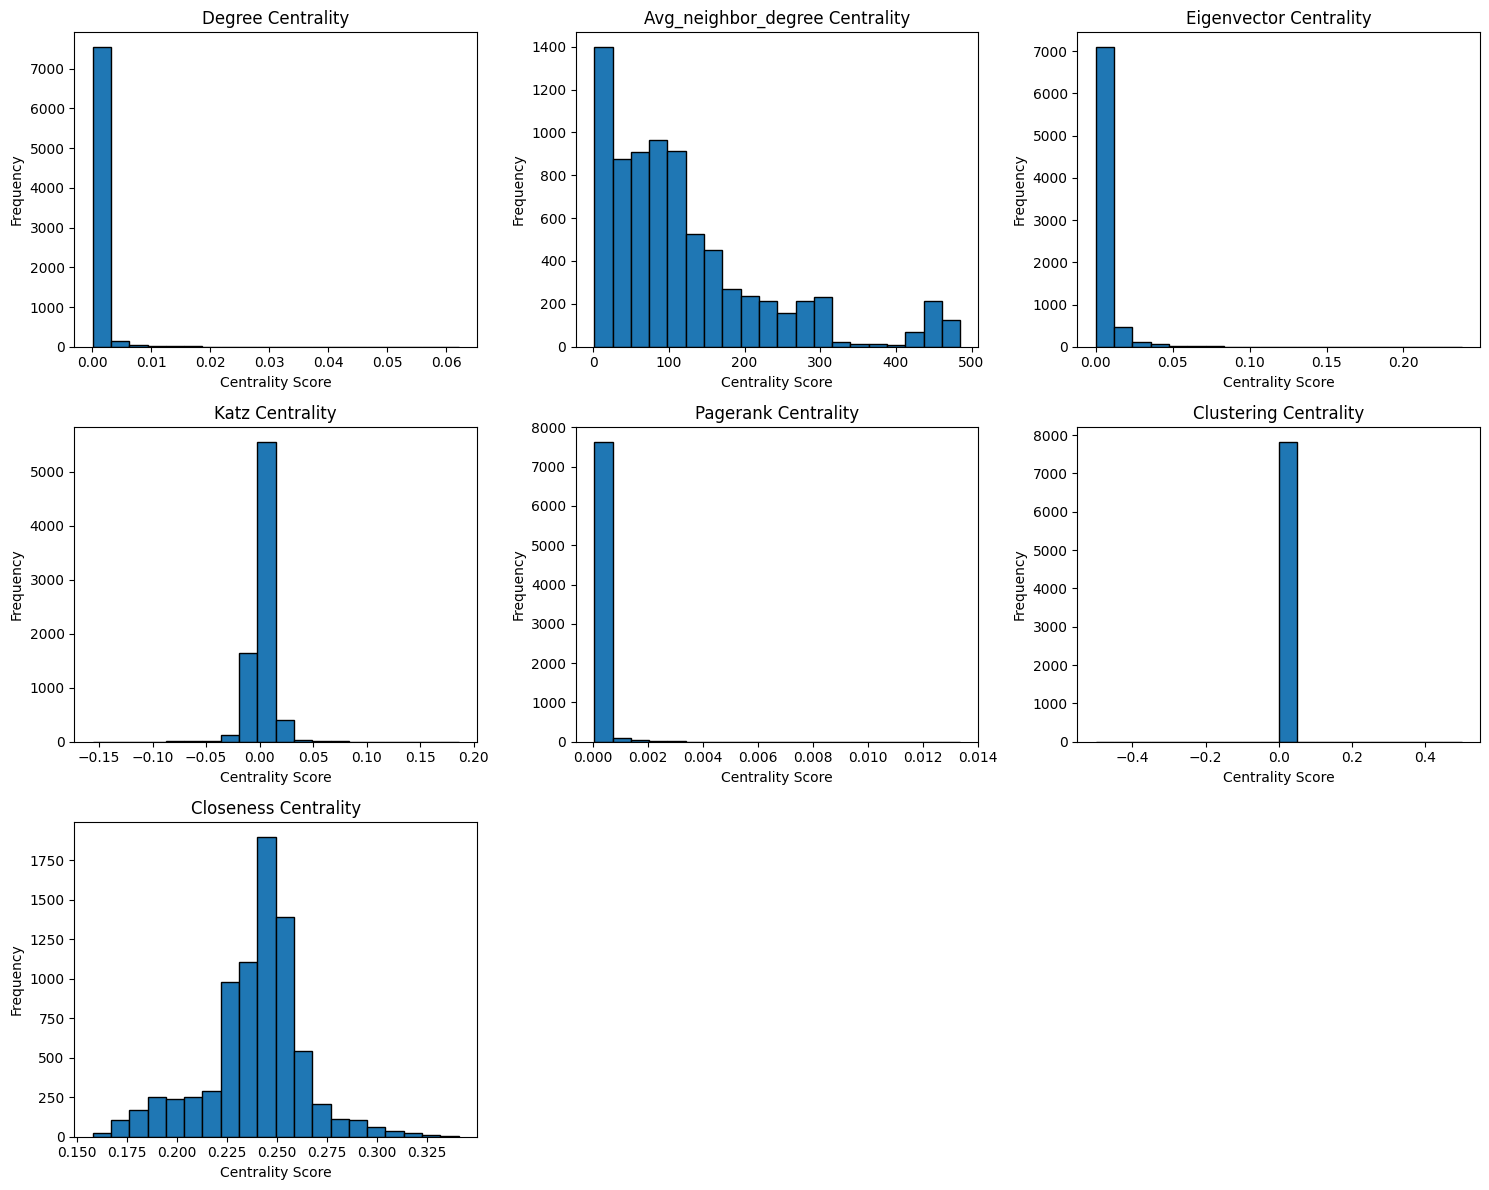

In [49]:
plot_centrality_histograms(centralities_full)

In [68]:
for measure, cent in centralities_full.items():
    if cent is None:
        continue
    print_top5_by_category(cent, G, measure)


Centrality Measure: Degree
  Top 5 Disease Nodes:
    "Prostatic Neoplasms" (ID: 239) - 0.0621
    "IGA Glomerulonephritis" (ID: 945) - 0.0576
    "Mammary Neoplasms" (ID: 561) - 0.0554
    "Obesity" (ID: 923) - 0.0381
    "Peripheral Neuropathy" (ID: 369) - 0.0375
  Top 5 Gene Nodes:
    7124 (ID: 272) - 0.0147
    6648 (ID: 118) - 0.0123
    5743 (ID: 392) - 0.0106
    3569 (ID: 208) - 0.0101
    7157 (ID: 276) - 0.0087

Centrality Measure: Avg_neighbor_degree
  Top 5 Disease Nodes:
    "Hypoglycemia" (ID: 621) - 40.5000
    "Leishmaniasis, Visceral" (ID: 249) - 37.4286
    "Cachexia" (ID: 841) - 36.3000
    "Papilloma" (ID: 297) - 36.2727
    "Liver Cirrhosis, Alcoholic" (ID: 151) - 36.0000
  Top 5 Gene Nodes:
    100188789 (ID: 5152) - 485.0000
    10040 (ID: 5154) - 485.0000
    10158 (ID: 5156) - 485.0000
    10263 (ID: 5160) - 485.0000
    10333 (ID: 5162) - 485.0000

Centrality Measure: Eigenvector
  Top 5 Disease Nodes:
    "Mammary Neoplasms" (ID: 561) - 0.2378
    "Prostati

In [51]:
centralities_small = compute_centralities(G_200_nodes)

Degre centrality computation duration:  0.0
Neighborhood connectivity computation duration:  0.0009987354278564453
Eigenvector centrality computation duration:  0.023300647735595703
Katz centrality computation duration:  0.0009958744049072266
Pagerank centrality computation duration:  0.0
Clustering centrality computation duration:  0.0
Closeness centrality computation duration:  0.01568460464477539


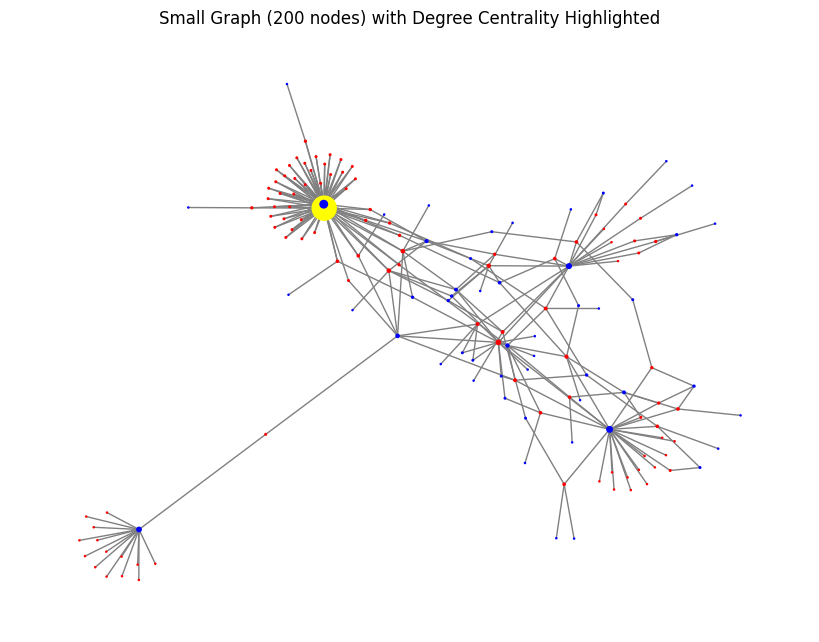

In [70]:
plot_graph_with_node_size(G_200_nodes, centralities_small["degree"], title="Small Graph (200 nodes) with Degree Centrality Highlighted", scale=100)


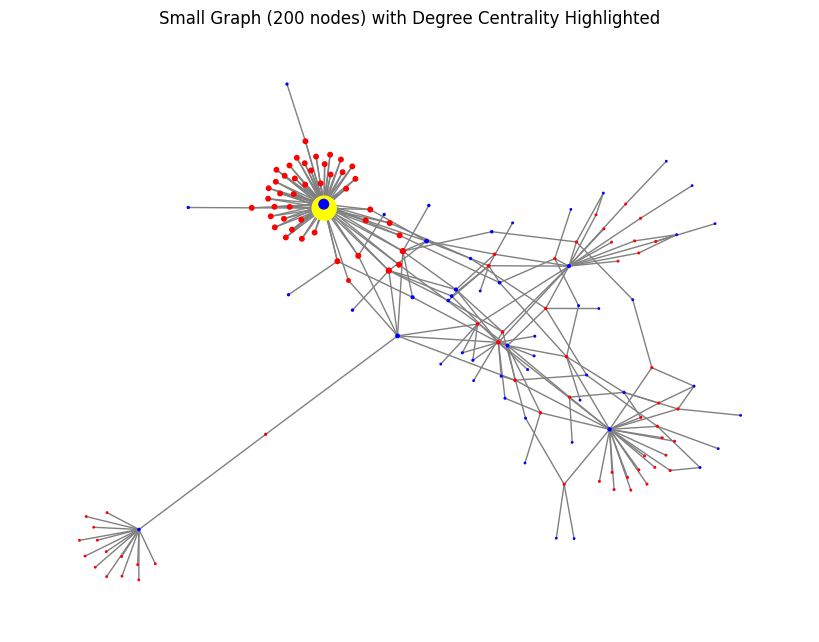

In [71]:
plot_graph_with_node_size(G_200_nodes, centralities_small["katz"], title="Small Graph (200 nodes) with Degree Centrality Highlighted", scale=100)


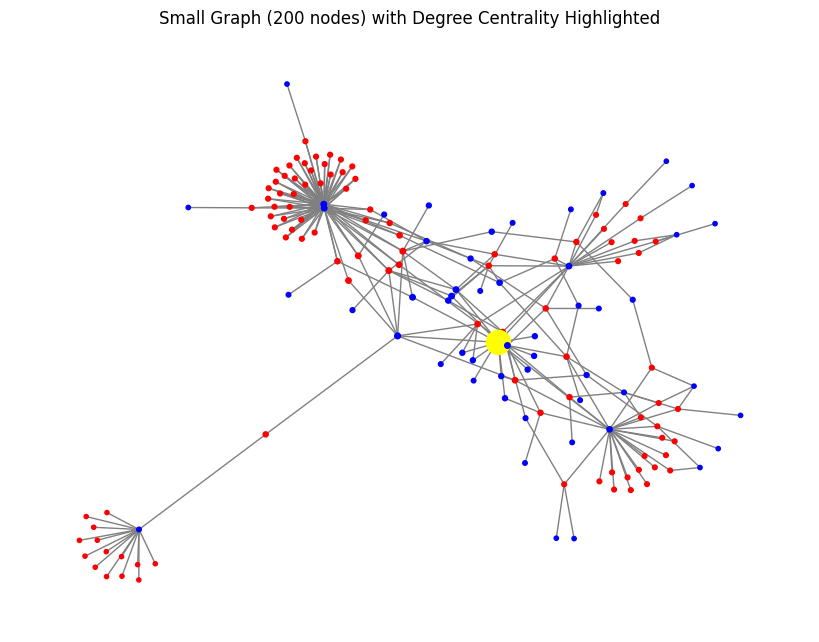

In [73]:
plot_graph_with_node_size(G_200_nodes, centralities_small["closeness"], title="Small Graph (200 nodes) with Degree Centrality Highlighted", scale=50)


# Community Detection

In [74]:
def plot_communities(G: nx.Graph, partition: dict, title: str = "Communities") -> None:
    """
    Plots the graph, coloring nodes by their 'community' (taken from partition dict)
    and differentiating diseases vs. genes by shape (circle vs. triangle).
    
    partition: dictionary {node: community_id} from a detection algorithm.
    """
    # Get node positions
    pos = nx.spring_layout(G, seed=42)
    
    # Map each community to a unique color
    communities = set(partition.values())
    # E.g. choose a color palette for up to, say, 20 communities:
    color_choices = plt.cm.get_cmap('tab20', len(communities))
    # Build a node list for each community
    community_color_map = {}
    for i, c in enumerate(sorted(communities)):
        community_color_map[c] = color_choices(i)

    # We will shape disease as 'o' and genes as '^'
    disease_nodes_by_comm = {}
    gene_nodes_by_comm = {}
    for node in G.nodes():
        comm_id = partition.get(node, 0)
        if G.nodes[node].get('category') == 'disease':
            disease_nodes_by_comm.setdefault(comm_id, []).append(node)
        else:
            gene_nodes_by_comm.setdefault(comm_id, []).append(node)
    
    # Plot
    plt.figure(figsize=(9, 7))
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')
    
    # For each community, draw disease nodes (circles) and gene nodes (triangles)
    for comm_id in communities:
        color = community_color_map[comm_id]
        # disease circle nodes
        d_nodes = disease_nodes_by_comm.get(comm_id, [])
        nx.draw_networkx_nodes(G, pos,
                               nodelist=d_nodes,
                               node_color=[color]*len(d_nodes),
                               node_shape='o',
                               node_size=120,
                               label=f"Community {comm_id} - disease" if len(d_nodes)>0 else "")
        # gene triangular nodes
        g_nodes = gene_nodes_by_comm.get(comm_id, [])
        nx.draw_networkx_nodes(G, pos,
                               nodelist=g_nodes,
                               node_color=[color]*len(g_nodes),
                               node_shape='^',
                               node_size=120,
                               label=f"Community {comm_id} - gene" if len(g_nodes)>0 else "")
    
    plt.title(title)
    plt.axis('off')
    plt.show()


In [75]:
def run_louvain(G: nx.Graph) -> dict:
    """
    Runs the Louvain community detection (python-louvain) on Graph G.
    Returns a dictionary {node: community_id}.
    """
    partition = community_louvain.best_partition(G)  # node -> community id
    return partition

def compute_modularity_louvain(G: nx.Graph, partition: dict) -> float:
    """
    Compute the modularity of a given partition (from Louvain) using python-louvain's modularity function.
    """
    # Convert G to the form needed by community_louvain (it can usually handle networkx Graph directly).
    # Then pass the partition dictionary directly.
    mod = community_louvain.modularity(partition, G)
    return mod

In [76]:
def run_girvan_newman_k_groups(G: nx.Graph, k: int = 4) -> dict:
    """
    Runs the Girvan–Newman approach to find a partition with k communities.
    Returns a dictionary {node: community_id}.
    We pick the partition at the iteration that yields k subsets.
    """
    gn_generator = nx.algorithms.community.girvan_newman(G)
    # girvan_newman yields partitions in order of increasing number of communities
    # We'll iterate until we get k communities, or we run out of partitions
    for partition_level in gn_generator:
        # partition_level is a tuple of sets, each set is a community
        if len(partition_level) == k:
            # Build a dict node-> community_id
            node2comm = {}
            for i, comm_set in enumerate(partition_level):
                for node in comm_set:
                    node2comm[node] = i
            return node2comm
    # If we never reached k communities, fallback to the last partition
    node2comm = {}
    # last partition from generator is not trivial to access once iter consumed,
    # so this approach just returns the best we can do.
    return node2comm

def compute_modularity_networkx(G: nx.Graph, partition: dict) -> float:
    """
    Compute modularity using networkx's built-in function:
      nx.algorithms.community.quality.modularity(G, communities)
    The partition must be a list of sets of nodes.
    """
    # Convert node->comm dictionary to a list of sets
    comm_map = {}
    for n, c in partition.items():
        comm_map.setdefault(c, set()).add(n)
    communities = list(comm_map.values())  # list of sets
    mod = nx.algorithms.community.quality.modularity(G, communities)
    return mod

Louvain found 8 communities. Modularity = 0.6212


C:\Users\merte\AppData\Local\Temp\ipykernel_18020\3244875216.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_choices = plt.cm.get_cmap('tab20', len(communities))


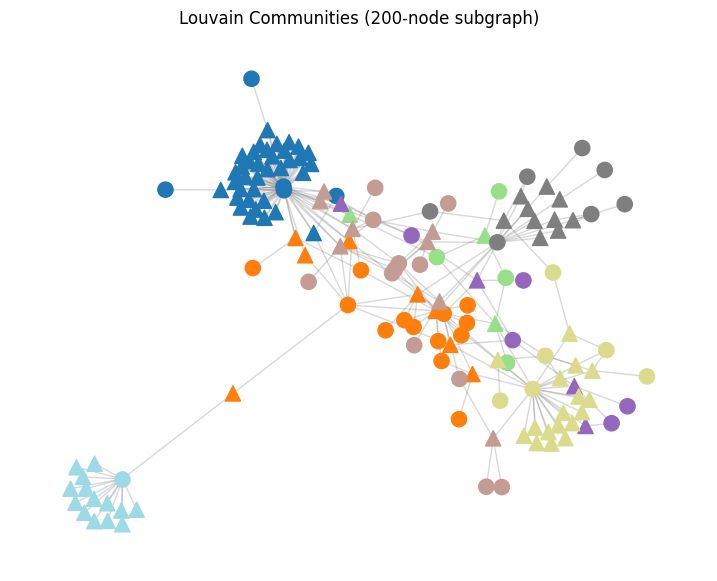

In [77]:
louvain_partition = run_louvain(G_200_nodes)
louvain_mod = compute_modularity_louvain(G_200_nodes, louvain_partition)
print(f"Louvain found {len(set(louvain_partition.values()))} communities. Modularity = {louvain_mod:.4f}")

# Visualize
plot_communities(G_200_nodes, louvain_partition, title="Louvain Communities (200-node subgraph)")



Girvan–Newman partition with 4 communities. Modularity = 0.6077


C:\Users\merte\AppData\Local\Temp\ipykernel_18020\3244875216.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_choices = plt.cm.get_cmap('tab20', len(communities))


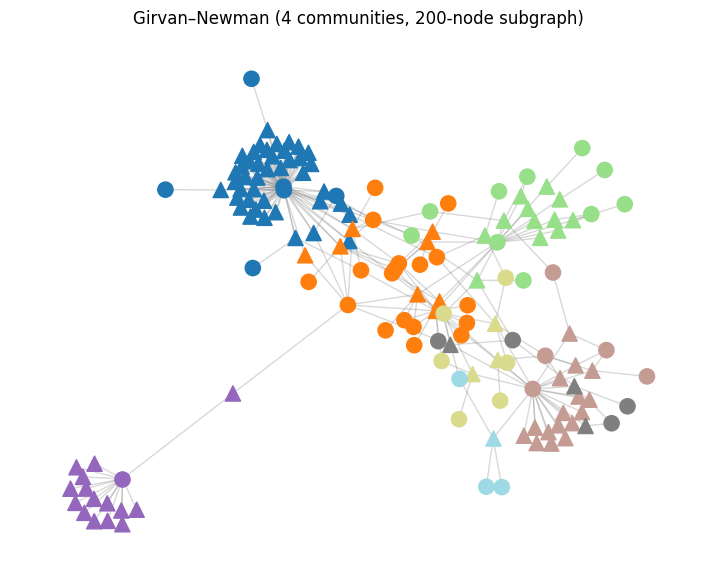

In [ ]:
girvan_partition_8 = run_girvan_newman_k_groups(G_200_nodes, k=8)
if not girvan_partition_8:
    print("Girvan–Newman did not find 8 communities; maybe graph is too small or too disconnected.")
else:
    mod_8 = compute_modularity_networkx(G_200_nodes, girvan_partition_8)
    print(f"Girvan–Newman partition with 8 communities. Modularity = {mod_8:.8f}")
    plot_communities(G_200_nodes, girvan_partition_8, title="Girvan–Newman (8 communities, 200-node subgraph)")


Girvan–Newman partition with 3 communities. Modularity = 0.393


C:\Users\merte\AppData\Local\Temp\ipykernel_18020\3244875216.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_choices = plt.cm.get_cmap('tab20', len(communities))


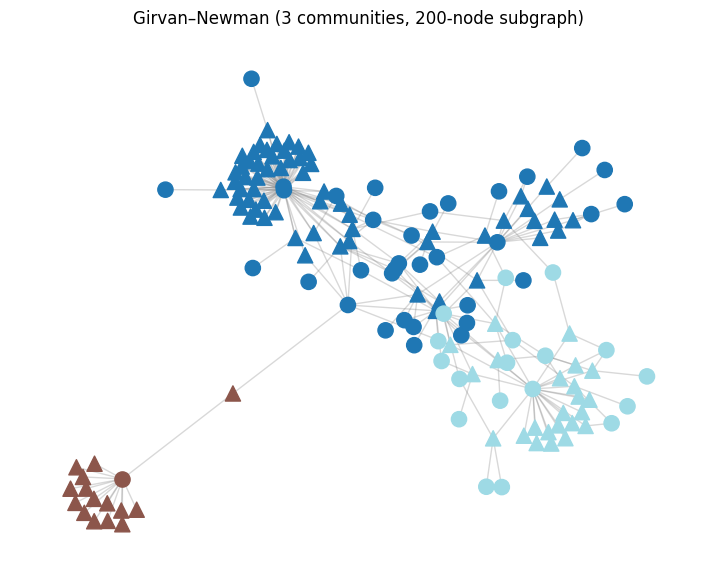

In [80]:
girvan_partition_3 = run_girvan_newman_k_groups(G_200_nodes, k=3)
if not girvan_partition_3:
    print("Girvan–Newman did not find 3 communities; maybe graph is too small or too disconnected.")
else:
    mod_3 = compute_modularity_networkx(G_200_nodes, girvan_partition_3)
    print(f"Girvan–Newman partition with 3 communities. Modularity = {mod_3:.3f}")
    plot_communities(G_200_nodes, girvan_partition_3, title="Girvan–Newman (3 communities, 200-node subgraph)")


# Graph Embedding

In [8]:
from node2vec import Node2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

c:\Users\merte\cs\graph\tp1\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def compute_node2vec_embedding(G: nx.Graph, dimensions: int = 16,
                               walk_length: int = 80, num_walks: int = 10,
                               window_size: int = 5, p: float = 1.0, q: float = 1.0) -> np.ndarray:
    """
    Computes Node2Vec embeddings for each node in G.
    Returns a numpy array shape (num_nodes, dimensions).
    The order of rows will match sorted(G.nodes()).
    
    Args:
      dimensions: dimension of embedding
      walk_length: length of each random walk
      num_walks: number of random walks per node
      window_size: skip-gram window size
      p, q: node2vec hyperparameters controlling BFS vs DFS bias
    """
    # Node2Vec requires consistent node IDs. We'll pass the graph as is, but we'll
    # need to remember to index them in sorted order to build a final array.
    node_order = sorted(G.nodes())
    node_index_map = {node: i for i, node in enumerate(node_order)}
    
    # Initialize node2vec from node2vec library
    n2v = Node2Vec(G,
                   dimensions=dimensions,
                   walk_length=walk_length,
                   num_walks=num_walks,
                   p=p,
                   q=q,
                   workers=1,   # Adjust as needed
                   quiet=True   # suppress progress bar
                  )
    # Fit model
    n2v_model = n2v.fit(window=window_size, min_count=1, batch_words=4)
    
    # Build embedding array
    emb_array = np.zeros((len(node_order), dimensions), dtype=np.float32)
    for node in node_order:
        emb_array[node_index_map[node]] = n2v_model.wv[str(node)]
    
    return emb_array, node_order


In [10]:
def compute_spectral_embedding(G: nx.Graph, k: int = 16) -> np.ndarray:
    """
    Computes a Laplacian-based spectral embedding of dimension k for each node in G.
    
    Returns:
      A numpy array of shape (num_nodes, k), where each row is the embedding of that node.
      The order of rows corresponds to sorted(G.nodes()) for consistency.
    """
    # 1) We need a consistent node ordering
    nodes_sorted = sorted(G.nodes())
    node_index_map = {node: idx for idx, node in enumerate(nodes_sorted)}
    n = len(nodes_sorted)
    
    # 2) Build adjacency matrix or Laplacian
    # For large graphs, you might consider a sparse approach (scipy.sparse).
    A = np.zeros((n, n), dtype=np.float32)
    for u, v in G.edges():
        i, j = node_index_map[u], node_index_map[v]
        A[i, j] = 1
        A[j, i] = 1
    
    # 3) Compute the (normalized) Laplacian: L = D - A, or the symmetric normalized version
    degrees = np.sum(A, axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(degrees, 1e-9)))
    I = np.eye(n)
    L = I - (D_inv_sqrt @ A @ D_inv_sqrt)  # Symmetric normalized Laplacian = I - D^-1/2 * A * D^-1/2
    
    # 4) Compute the bottom k+1 eigenvectors of L. We typically skip the first eigenvector (the trivial 0 eigenvalue).
    # We can use np.linalg.eigh, but be mindful of memory for large n. For a smaller or moderate graph this is okay.
    w, v = np.linalg.eigh(L)  # w: eigenvals, v: eigenvecs
    # Eigenvalues/eigenvectors are sorted in ascending order by w
    # Typically the 0 eigenvalue is w[0], so let's skip the first and take next k
    # However, note that if the graph is not fully connected, there might be multiple 0 eigenvalues.
    
    # We'll pick the smallest k non-trivial eigenvectors. We'll skip the first eigenvector if it's the trivial one.
    # If we want exactly k dims, we can skip the first dimension with w=0, then take next k. We can also detect how many 0's are present
    # For simplicity, let's skip the first vector and take the next k:
    embedding = v[:, 1:(1 + k)]
    
    # embedding shape is (n, k). Each row i is the embedding for node nodes_sorted[i].
    return embedding, nodes_sorted


In [11]:
def compute_silhouette(embeddings: np.ndarray, labels: np.ndarray) -> float:
    """
    Computes the silhouette score for the given embeddings (dim = NxD)
    with a label array of shape (N,). Typically in classification,
    a higher silhouette means better separation among classes.
    """
    if len(np.unique(labels)) < 2:
        return -1  # silhouette needs >= 2 clusters
    return silhouette_score(embeddings, labels)

In [12]:
from sklearn.manifold import TSNE

def reduce_to_2d(embeddings: np.ndarray, method: str = "pca") -> np.ndarray:
    """
    Reduces embeddings to 2D with PCA or t-SNE.
    Returns an array shape (num_nodes, 2).
    """
    if method.lower() == "pca":
        pca = PCA(n_components=2)
        coords_2d = pca.fit_transform(embeddings)
    else:
        # fallback t-SNE
        tsne = TSNE(n_components=2, perplexity=30.0, random_state=42)
        coords_2d = tsne.fit_transform(embeddings)
    return coords_2d

def plot_embeddings_2d(coords_2d: np.ndarray, G: nx.Graph, node_order: list, title: str = "") -> None:
    """
    Creates a scatter plot of the 2D coordinates, coloring by category (disease vs. gene).
    node_order matches the row ordering of coords_2d.
    """
    # Identify diseases vs. genes
    categories = []
    for node in node_order:
        cat = G.nodes[node].get('category', 'unknown')
        categories.append(cat)
    
    xs = coords_2d[:, 0]
    ys = coords_2d[:, 1]
    
    # We'll color diseases in blue, genes in red
    colors = ['blue' if cat=='disease' else 'red' for cat in categories]
    
    plt.figure(figsize=(8,6))
    plt.scatter(xs, ys, c=colors, alpha=0.7, s=10)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.show()



In [13]:
spectral_embed, node_order = compute_spectral_embedding(G, k=16)
print("Spectral embedding shape:", spectral_embed.shape)


Spectral embedding shape: (7813, 16)


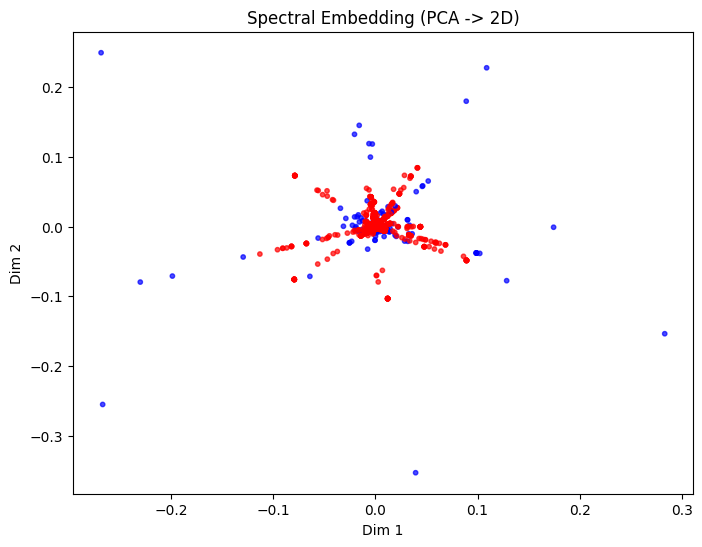

In [14]:
spec_coords_2d_pca = reduce_to_2d(spectral_embed, method="pca")
plot_embeddings_2d(spec_coords_2d_pca, G, node_order, title="Spectral Embedding (PCA -> 2D)")

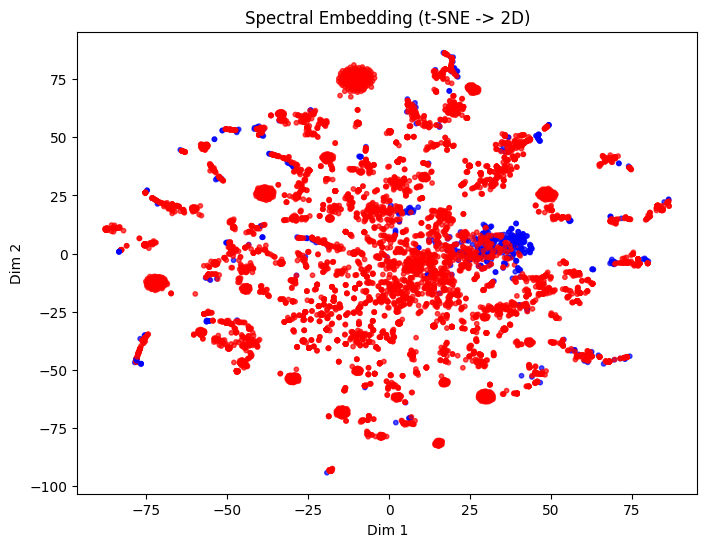

In [15]:
spec_coords_2d_tsne = reduce_to_2d(spectral_embed, method="tsne")
plot_embeddings_2d(spec_coords_2d_tsne, G, node_order, title="Spectral Embedding (t-SNE -> 2D)")

In [16]:
n2v_embed, node_order_2 = compute_node2vec_embedding(
    G, dimensions=16, walk_length=80, num_walks=10,
    window_size=5, p=1.0, q=1.0
)
print("Node2Vec embedding shape:", n2v_embed.shape)


Node2Vec embedding shape: (7813, 16)


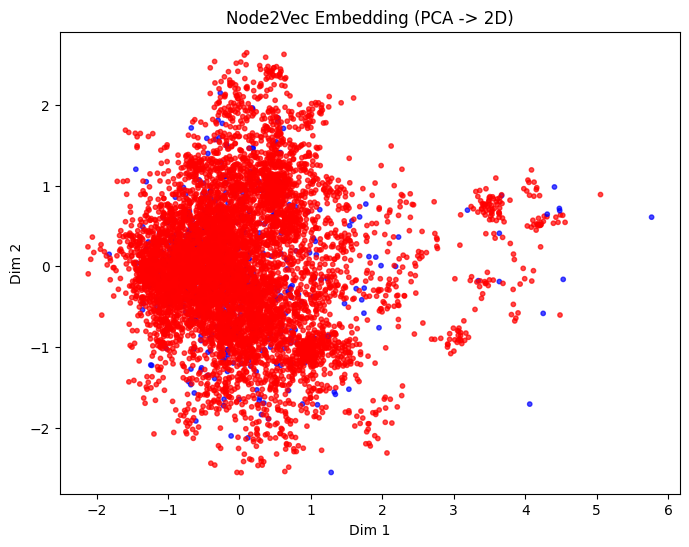

In [17]:
n2v_coords_2d_tsne = reduce_to_2d(n2v_embed, method="pca")
plot_embeddings_2d(n2v_coords_2d_tsne, G, node_order_2, title="Node2Vec Embedding (PCA -> 2D)")


# GNN

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import random
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric.transforms as T

from plotly import graph_objs as go
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.model_selection import ParameterGrid
from torch_geometric.data import Data, download_url, extract_gz
from torch_geometric.nn import GAE, GCNConv, VGAE
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import train_test_split_edges, negative_sampling, degree


In [3]:
# set the seeds
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [24]:
def load_node_mapping(datafile_path, index_col, offset=0):
  """
  Maps each distinct node to a unique integer index.

  Args: datafile_path, string name of the tsv file containing the graph data
        index_col, string name of the column containing the nodes of concern
        offset, amount to shift the generated indexes by
  Returns: the mapping from node name to integer index
  """
  df = pd.read_csv(datafile_path, index_col=index_col, sep="\t")
  mapping = {index_id: i + offset for i, index_id in enumerate(df.index.unique())}
  return mapping

def load_edge_list(datafile_path, src_col, src_mapping, dst_col, dst_mapping):
  """
  Given node mappings, returns edge list in terms of node integer indices.

  Args: datafile_path, string name of the tsv file containing the graph data
        src_col, string name of the column corresponding to source nodes
        src_mapping, mapping from source node name to integer index
  Returns: the mapping from node name to integer index
  """
  df = pd.read_csv(datafile_path, sep="\t")
  src_nodes = [src_mapping[index] for index in df[src_col]]
  dst_nodes = [dst_mapping[index] for index in df[dst_col]]
  edge_index = torch.tensor([src_nodes, dst_nodes])
  return edge_index

def initialize_data(datafile_path, num_features=1):
  """
  Given a tsv file specifying disease-gene interactions, index the nodes and
  construct a Data object.
  """
  # Get disease node mapping and gene node mapping.
  # Each node type has its own set of integer ids.
  dz_col, gene_col = "# Disease ID", "Gene ID"
  dz_mapping = load_node_mapping(datafile_path, dz_col, offset=0)
  gene_mapping = load_node_mapping(datafile_path, gene_col, offset=519)

  # Get edge index in terms of the integer indeces assigned to the nodes.
  edge_index = load_edge_list(
      datafile_path, dz_col, dz_mapping, gene_col, gene_mapping)

  # Add the reverse direction (aka make it a undirected graph)
  rev_edge_index = load_edge_list(
      datafile_path, gene_col, gene_mapping, dz_col, dz_mapping)

  # Construct a Data object.
  data = Data()
  data.num_nodes = len(dz_mapping) + len(gene_mapping)
  data.edge_index = torch.cat((edge_index, rev_edge_index), dim=1)
  # pretend we have uniform node features
  data.x = torch.ones((data.num_nodes, num_features))

  return data, gene_mapping, dz_mapping

In [35]:
# Read data and construct Data object.
data_object, gene_mapping, dz_mapping = initialize_data('data_disease\DG-AssocMiner_miner-disease-gene.tsv')
print(data_object)
print("Number of genes:", len(gene_mapping))
print("Number of diseases:", len(dz_mapping))

Data(num_nodes=7813, edge_index=[2, 42714], x=[7813, 1])
Number of genes: 7294
Number of diseases: 519


In [36]:
NUM_FEATURES =   20

In [37]:
data_object.x = torch.ones((data_object.num_nodes, NUM_FEATURES))
print("Using dummy embeddings as initial node features.")
print("Number of features set to ", NUM_FEATURES)

Using dummy embeddings as initial node features.
Number of features set to  20


In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
transform = T.Compose([
    # T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.15, is_undirected=True,
                      split_labels=True, add_negative_train_samples=True),
])

train_dataset, val_dataset, test_dataset = transform(data_object)
print("Train Data:\n", train_dataset)
print("Validation Data:\n", val_dataset)
print("Test Data:\n", test_dataset)

Train Data:
 Data(num_nodes=7813, edge_index=[2, 34174], x=[7813, 20], pos_edge_label=[17087], pos_edge_label_index=[2, 17087], neg_edge_label=[17087], neg_edge_label_index=[2, 17087])
Validation Data:
 Data(num_nodes=7813, edge_index=[2, 34174], x=[7813, 20], pos_edge_label=[1067], pos_edge_label_index=[2, 1067], neg_edge_label=[1067], neg_edge_label_index=[2, 1067])
Test Data:
 Data(num_nodes=7813, edge_index=[2, 36308], x=[7813, 20], pos_edge_label=[3203], pos_edge_label_index=[2, 3203], neg_edge_label=[3203], neg_edge_label_index=[2, 3203])


In [40]:
def get_mapping():
  data_path = "data_disease\DG-AssocMiner_miner-disease-gene.tsv"
  df = pd.read_csv(data_path, index_col="Disease Name", sep="\t")
  disease_mapping = [index_id for index_id in enumerate(df.index.unique())]
  df = pd.read_csv(data_path, index_col="Gene ID", sep="\t")
  gene_mapping = [index_id[1] for index_id in enumerate(df.index.unique())]
  mapping = disease_mapping + gene_mapping
  return mapping

def visualize_tsne_embeddings(model, data, title, perplexity=30.0,
                              labeled=False, labels=[]):
  """Visualizes node embeddings in 2D space with t-SNE.

  Args: model, pass in the trained or untrained model
        data, Data object, where we assume the first 519 datapoints are disease
          nodes and the rest are gene nodes
        title, title of the plot
        perplexity, t-SNE hyperparameter for perplexity
  """
  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index)
  ax1, ax2 = zip(*TSNE(n_components=2, learning_rate='auto', perplexity=perplexity,
                       init='random').fit_transform(z.detach().cpu().numpy()))

  fig = px.scatter(x=ax1, y=ax2, color=['r']*519 + ['g']*7294,
                   hover_data=[get_mapping()],
                   title=title)

  if labeled:
    for i in labels:
      fig.add_annotation(x=ax1[i], y=ax2[i],
                         text=str(i), showarrow=False)
  fig.show()

def visualize_pca_embeddings(model, data, title, labeled=False, labels=[]):
  """Visualizes node embeddings in 2D space with PCA (components=2)

  Args: model, pass in the trained or untrained model
        data, Data object, where we assume the first 519 datapoints are disease
          nodes and the rest are gene nodes
        title, title of the plot
  """
  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index)

  pca = PCA(n_components=2)
  components = pca.fit_transform(z.detach().cpu().numpy())
  fig = px.scatter(components, x=0, y=1, color=['r']*519 + ['g']*7294,
                   hover_data=[get_mapping()], title=title)

  if labeled:
    for i in labels:
      fig.add_annotation(x=components[:,0][i], y=components[:,1][i],
                         text=str(i), showarrow=False)
  fig.show()

In [41]:
def plot_roc_curve(model, data):
  """Visualizes ROC curve of model predictions

  Args: model, pass in the trained or untrained model
        data, Data object, where we assume the first 519 datapoints are disease
  """
  model.eval()

  x = data.x
  z = model.encode(x, data.edge_index)

  pos_preds = model.decode(z, data.pos_edge_label_index, sigmoid=True)
  neg_preds = model.decode(z, data.neg_edge_label_index, sigmoid=True)
  preds = torch.cat([pos_preds, neg_preds], dim=0)
  preds = preds.detach().cpu().numpy()

  labels = torch.cat((data.pos_edge_label, data.neg_edge_label), dim=0)
  labels = labels.detach().cpu().numpy()
  fpr, tpr, thresholds = metrics.roc_curve(labels, preds)

  # Using J-statistic: https://en.wikipedia.org/wiki/Youden%27s_J_statistic
  J = tpr - fpr
  ix = np.argmax(J)
  best_thresh = thresholds[ix]
  print('Best Threshold=%f' % (best_thresh))

  roc_auc = metrics.roc_auc_score(labels, preds)

  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.plot([0, 1], [0, 1],'r--') # diagonal roc curve of a random classifier
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best=%0.2f' % best_thresh)
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc = 'lower right')
  plt.title('ROC curve for model predictions')
  plt.show()

In [42]:
def plot_training_stats(title, losses, test_auc, test_ap, train_auc, train_ap):
  """Plots evolution of loss and metrics during training

  Args: losses, test_auc, test_ap, train_auc, and train_ap should be lists
    outputted by the training process.
  """
  fig, ax = plt.subplots()
  ax2 = ax.twinx()

  ax.set_xlabel("Training Epochs")
  ax2.set_ylabel("Performance Metric")
  ax.set_ylabel("Loss")

  plt.title(title)
  p1, = ax.plot(losses, "b-", label="training loss")
  p2, = ax2.plot(test_auc, "r-", label="test AUC")
  p3, = ax2.plot(test_ap, "g-", label="test AP")
  p4, = ax2.plot(train_auc, "o-", label="train AUC")
  p5, = ax2.plot(train_ap, "v-", label="train AP")
  plt.legend(handles=[p1, p2, p3, p4, p5])
  plt.show()

In [43]:
def get_edge_dot_products(data, model, num_dz_nodes=519):
  """
  A pair of nodes (u,v) is predicted to be connected with an edge if the dot
  product between the learned embeddings of u and v is high. This function
  computes and returns the dot product of all pairs of (dz_node, gene_node).

  Args:
    data, the data_object containing the original node featues
    model, the model that will be used to encode the data
    num_dz_nodes, the number of disease nodes; used to differentiate between
      disease and gene node embeddings
  Returns:
    dot_products, a numpy 2D array of shape (num_dz_nodes, num_gene_nodes)
      containing the dot product between each (dz_node, gene_node) pair.
  """
  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index).detach().numpy()
  dz_z = z[:num_dz_nodes, :]
  gene_z = z[num_dz_nodes:, :]

  dot_products = np.einsum('ai,bi->ab', dz_z, gene_z)
  return dot_products   # numpy array of shape (num_dz_nodes, num_gene_nodes)


def get_ranked_edges(data_object, model, num_dz_nodes=519):
  """
  Ranks all potential edges as predicted by the model.

  Args:
    data, the data_object containing the original node featues
    model, the model that will be used to encode the data
    num_dz_nodes, the number of disease nodes; used to differentiate between
      disease and gene node embeddings
  Returns:
    ranked_edge_list, a full edge list ranked by the likelihood of the edge
      being a positive edge, in decreasing order
    ranked_dot_products, a list of the dot products of each edge's node
      embeddings, ranked in decreasing order
  """
  # Get dot products
  edge_dot_products = get_edge_dot_products(data_object, model, num_dz_nodes=num_dz_nodes)
  num_possible_edges = edge_dot_products.shape[0] * edge_dot_products.shape[1]

  # Get indeces, ranked by dot product in descending order. This is a tuple (indeces[0], indeces[1]).
  ranked_edges = np.unravel_index(np.argsort(-1 * edge_dot_products, axis=None), edge_dot_products.shape)
  assert len(ranked_edges[0]) == num_possible_edges

  # Get the corresponding, ranked edge list and ranked dot products. Note that
  # we need to add an offset for the gene_node indeces.
  offset = np.array([np.zeros(num_possible_edges, dtype=int), num_dz_nodes + np.ones(num_possible_edges, dtype=int)]).T
  ranked_edge_list = np.dstack(ranked_edges)[0] + offset
  assert ranked_edge_list.shape[0] == num_possible_edges

  # Get the corresponding ranked dot products
  ranked_dot_products = edge_dot_products[ranked_edges]
  assert ranked_dot_products.shape[0] == num_possible_edges

  return ranked_edge_list, ranked_dot_products


In [14]:
HIDDEN_SIZE = 200

OUT_CHANNELS = 20

EPOCHS =   40

In [22]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_size, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(hidden_size, out_channels, cached=True) # cached only for transductive learning
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv2(x_temp2, edge_index)


gae_model = GAE(GCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.5))
gae_model = gae_model.to(device)

In [16]:
def gae_train(train_data, gae_model, optimizer):
    gae_model.train()
    optimizer.zero_grad()
    z = gae_model.encode(train_data.x, train_data.edge_index)
    loss = gae_model.recon_loss(z, train_data.pos_edge_label_index.to(device))
    loss.backward(retain_graph=True)
    optimizer.step()
    return float(loss)

@torch.no_grad()
def gae_test(test_data, gae_model):
    gae_model.eval()
    z = gae_model.encode(test_data.x, test_data.edge_index)
    return gae_model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)


In [17]:
visualize_tsne_embeddings(gae_model, train_dataset, 'Untrained GAE: train set embeddings t-SNE', labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

In [44]:
visualize_pca_embeddings(gae_model, train_dataset, 'Untrained GAE: train set embeddings PCA', labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

In [45]:
losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []


optimizer = torch.optim.Adam(gae_model.parameters(), lr=0.01)

for epoch in range(1, EPOCHS + 1):
    gae_model.train()
    optimizer.zero_grad()
    z = gae_model.encode(train_dataset.x, train_dataset.edge_index)
    loss = gae_model.recon_loss(z, train_dataset.pos_edge_label_index.to(device))
    loss.backward(retain_graph=True)
    optimizer.step()

    losses.append(float(loss))
    auc, ap = gae_test(test_dataset, gae_model)
    test_auc.append(auc)
    test_ap.append(ap)

    train_auc, train_ap = gae_test(train_dataset, gae_model)

    train_aucs.append(train_auc)
    train_aps.append(train_ap)

    print('Epoch: {:03d}, test AUC: {:.4f}, test AP: {:.4f}, train AUC: {:.4f}, train AP: {:.4f}, loss:{:.4f}'.format(epoch, auc, ap, train_auc, train_ap, loss))

Epoch: 001, test AUC: 0.9495, test AP: 0.9459, train AUC: 0.9472, train AP: 0.9436, loss:2.2514
Epoch: 002, test AUC: 0.9499, test AP: 0.9462, train AUC: 0.9477, train AP: 0.9440, loss:1.5867
Epoch: 003, test AUC: 0.9498, test AP: 0.9461, train AUC: 0.9476, train AP: 0.9439, loss:1.5993
Epoch: 004, test AUC: 0.9497, test AP: 0.9460, train AUC: 0.9474, train AP: 0.9437, loss:1.3551
Epoch: 005, test AUC: 0.9491, test AP: 0.9455, train AUC: 0.9468, train AP: 0.9432, loss:1.2392
Epoch: 006, test AUC: 0.9484, test AP: 0.9449, train AUC: 0.9461, train AP: 0.9426, loss:1.2066
Epoch: 007, test AUC: 0.9473, test AP: 0.9440, train AUC: 0.9450, train AP: 0.9417, loss:1.2066
Epoch: 008, test AUC: 0.9473, test AP: 0.9440, train AUC: 0.9451, train AP: 0.9417, loss:1.2124
Epoch: 009, test AUC: 0.9471, test AP: 0.9439, train AUC: 0.9448, train AP: 0.9415, loss:1.2045
Epoch: 010, test AUC: 0.9471, test AP: 0.9438, train AUC: 0.9449, train AP: 0.9415, loss:1.2058
Epoch: 011, test AUC: 0.9473, test AP: 0

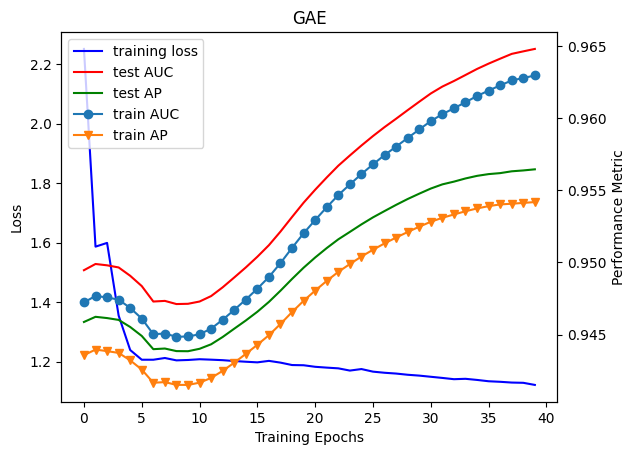

In [46]:
plot_training_stats('GAE', losses, test_auc, test_ap, train_aucs, train_aps)

Best Threshold=0.606186


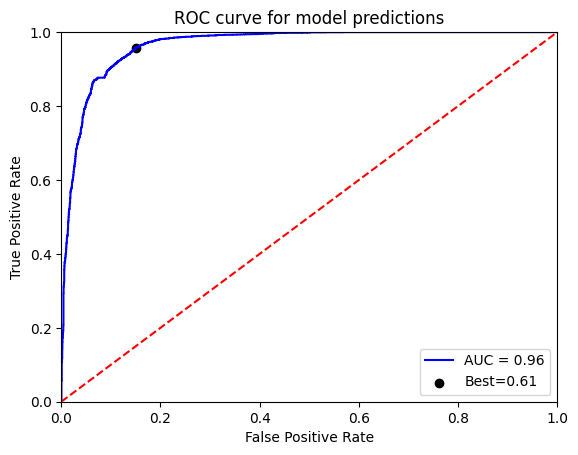

In [47]:
plot_roc_curve(gae_model, test_dataset)

In [ ]:
visualize_tsne_embeddings(
    gae_model, train_dataset, title='Trained GAE: train set embeddings',
    perplexity=5, labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

In [48]:
visualize_pca_embeddings(
    gae_model, train_dataset, title='Trained GAE: train set embeddings',
    labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])